In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import gensim
import re
import nltk
from tqdm import tqdm

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

In [3]:
#Set working directory
#@title Set up Directory { run: "auto"}
import os
from IPython.display import clear_output
from google.colab import drive 
from IPython.display import clear_output
drive.mount('/content/gdrive')
working_directory = 'My Drive/Khairiyah_Bte_Mohamed_Ridhwan/topic_modelling/notebooks' #@param {type:"string"}
wd="/content/gdrive/"+working_directory
os.chdir(wd)

dirpath = os.getcwd()
print("current directory is : " + dirpath)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
current directory is : /content/gdrive/My Drive/Khairiyah_Bte_Mohamed_Ridhwan/topic_modelling/notebooks


In [4]:
# Import customs module to tokenize and clean tweet dataset
from clean_tokenizer import tokenize_tweets, clean_tweet
tweets_df = pd.read_csv('data/tweets_final.csv') 
tweets_df.shape

(5267, 17)

In [5]:
date = pd.to_datetime(tweets_df['Datetime'], format='%Y-%m-%d')
tweets_df['date'] = date.dt.date

# Convert date to datetime
tweets_df['date'] = pd.to_datetime(tweets_df['date'], errors='coerce')

# Add column for month
tweets_df['month'] = tweets_df['date'].dt.month

# Add column for week number
tweets_df['week'] = tweets_df['date'].apply(lambda x: x.isocalendar()[1])

### Frequency of tweets daily

In [6]:
# Get the frequency of tweet with each emotions daily

import plotly.express as px
import datetime

#plt.rcParams['figure.figsize'] = [55, 30]

no_of_tweets_perday = tweets_df.groupby(['week']).size().reset_index(name='counts')
no_of_tweets_perday



fig = px.line(no_of_tweets_perday, x="week", y="counts", title="Number of tweets per week related to COVID-19 in Singapore")
fig.update_layout(
    xaxis_title="Week number of 2020",
    yaxis_title="Tweet counts",
    font=dict(size=14
    )
)

fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= 6, x1= 6,line=dict(
        color="Black",
        width=1.2,
        dash="dot",
    )
    ),
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= 12, x1= 12,line=dict(
        color="Black",
        width=1.2,
        dash="dot",
    )
    ),
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= 15, x1= 15,line=dict(
        color="Black",
        width=1.2,
        dash="dot",
    )
    )])


fig.add_annotation(
     x=6,
        y=0.98,
        xref="x",
        yref="paper",
        text="[A]"
        )

fig.add_annotation(
     x=12,
        y=0.98,
        xref="x",
        yref="paper",
        text="[B]"
        )

fig.add_annotation(
     x=15,
        y=0.98,
        xref="x",
        yref="paper",
        text="[C]"
        )


fig.show()

# !pip install plotly>=4.0.0
# !wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
# !chmod +x /usr/local/bin/orca
# !apt-get install xvfb libgtk2.0-0 libgconf-2-4
# fig.write_image("plot_outputs/weekly_overall.png")

### Preprocessing: Dictionary and tokenizing

In [7]:
import nltk
nltk.download('wordnet')
# Convert cleaned tweet into tokens list
tweets_df['Text']=tweets_df['Text'].apply(str)
tweets_df['Text'] = tweets_df['Text'].replace({'govt':'government', 'Govt':'Government'} )
tweets_df['clean_text_new']=tweets_df['Text'].apply(clean_tweet, bigrams=True) 
#   Note: clean_tweet function will: 
# -	remove retweet and @user information
# -	remove web links
# -	remove hashtags
# -	remove audio/video tags or labels
# -	lower case the tweet
# -	strip punctuation
# -	remove double spacing
# -	remove numbers
# -	apply lemmatization and tokenization (within lemmatize function, remove stop words drops words with 3 or less characters
# -	form bigrams
tweets_df.head()
tweets_df['clean_tokens'] = tweets_df.clean_text_new.apply(lambda x: re.split('\s', x))
#remove additional custom stopwords
stop = ["pm","t.co","http","https","amp","t","t.c","c","rt", "pl", "sg","singapore", "covid-19","coronavirus", "covid",
        "covid19","wuhan", "s", "p", "like", "im","new", "day", "days","year", "ur", "ve", "la", "ive", "cos", "guys",
        "didnt", "time", "people", "dont", "today", "thing", "week", "months", "post","yesterday", "man", "wont", "uk",
        "st", "lets", "don", "feel", "feeling", "gonna","isnt", "pls", "share", "wait", "wanna", "na", "back", "means",
        "fuck", "fucking", "lah", "good","due", "sa", "ingat", "sa covid", "just", "will", "can", "now", "get", "go", "us",
        "can", "one", "even", "just", "ada", "ke", "got", "going", "last", "etc", "kaypo", "still", "chibai", "woodlands",
        "singapore", "woodlands_singapore", "say", "know", "virus","situation", "need", "want", "take", "come", "look",
        "think", 'actually', 'especially', 'later', 'guess', 'note', 'dear', 'road', 'start', 'stop', 'things', 'give',
        'try', 'tell', 'shit', 'maybe', 'keep', 'right','time', 'march_march', 'stacy',  'time_coronavirus', 'amid_covid', 
        'ingat_covid', 'iwas','mall','bedok', 'control', 'lawrence', 'wong', 'lawrence_wong', 'feel_like']
tweets_df['clean_tokens_final']= tweets_df['clean_tokens'].apply(lambda x: [item for item in x if item not in stop])
tweets_df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,Unnamed: 0,Datetime,Tweet.URL,Tweet.Id,Tweet.User.Id,Text,Username,User.Location,replyCount,retweetCount,likeCount,quoteCount,language,retweetedTweet,quotedTweet,mentionedUsers,clean_text,date,month,week,clean_text_new,clean_tokens,clean_tokens_final
0,1,2020-08-31 22:27:32+00:00,https://twitter.com/VishnoiSays/status/1300560...,1.300561e+18,8.134247e+07,Canada Buying Doses of Covid-19 Vaccine From N...,VishnoiSays,Singapore,0,0,0,0,en,NaN,NaN,NaN,canada buying doses covid vaccine novavax j amp j,2020-08-31,8,36,canada buy dose covid vaccine novavax canada_b...,"[canada, buy, dose, covid, vaccine, novavax, c...","[canada, buy, dose, vaccine, novavax, canada_b..."
1,2,2020-08-31 22:27:32+00:00,https://twitter.com/VishnoiSays/status/1300560...,1.300561e+18,8.134247e+07,Heat Waves Hurting Cities Most Vulnerable to C...,VishnoiSays,Singapore,0,0,0,0,en,NaN,NaN,NaN,heat waves hurting cities vulnerable covid,2020-08-31,8,36,heat wave hurt cities vulnerable covid heat_wa...,"[heat, wave, hurt, cities, vulnerable, covid, ...","[heat, wave, hurt, cities, vulnerable, heat_wa..."
2,3,2020-08-31 16:07:16+00:00,https://twitter.com/onefern/status/13004651859...,1.300465e+18,5.447890e+08,One of my fave after dinner snacks nowadays if...,onefern,Singapore,0,0,0,0,en,NaN,NaN,NaN,one fave dinner snacks nowadays m still peckis...,2020-08-31,8,36,fave dinner snack nowadays peckish period fave...,"[fave, dinner, snack, nowadays, peckish, perio...","[fave, dinner, snack, nowadays, peckish, perio..."
3,4,2020-08-31 14:25:48+00:00,https://twitter.com/sinsica/status/13004396509...,1.300440e+18,2.384276e+08,Please be safe guys .. take all precautions an...,sinsica,Singapore,0,0,1,0,en,NaN,NaN,NaN,please safe guys take precautions safety measu...,2020-08-31,8,36,safe guy precautions safety measure avoid crow...,"[safe, guy, precautions, safety, measure, avoi...","[safe, guy, precautions, safety, measure, avoi..."
4,5,2020-08-31 11:49:25+00:00,https://twitter.com/heroroxas/status/130040029...,1.300400e+18,1.964754e+09,Where i'd rather be kasi it's covid-free #tb @...,heroroxas,NaN,0,0,0,0,en,NaN,NaN,NaN,d rather kasi s covid free batanes philippines,2020-08-31,8,36,kasi covid free batanes philippines kasi_covid...,"[kasi, covid, free, batanes, philippines, kasi...","[kasi, free, batanes, philippines, kasi_covid,..."


In [8]:
all_words = [word for item in list(tweets_df['clean_tokens_final']) for word in item]
#all_words

#frequency distribution of all terms
fdist = nltk.FreqDist(all_words)

#number of unique terms
len(fdist)
#fdist

48057

In [9]:
#create dataframe of terms with their respective frequency
fdist = pd.DataFrame.from_dict(fdist, orient='index').reset_index()
fdist.columns = ['word', 'freq']
fdist = fdist.sort_values('freq', ascending=False)

In [10]:
#discard words containing only 1 character
fdist = fdist[fdist.apply(lambda r: len(r['word']) > 1, axis=1)]

#discard numbers/digits
fdist = fdist[fdist.apply(lambda r: r['word'].isdigit() == False, axis=1)]

#select terms that appear at least 10 times
fdist = fdist[(fdist.freq >= 10)]

In [11]:
fdist.head()

,word,freq
196,case,365
397,home,352
1347,stay,295
378,work,272
248,world,230


In [12]:
len(fdist)

1028

In [13]:
#dictionary to collect order of mapping
dict_word = {}
for i in range(len(fdist)):
    temp = fdist.iloc[i]
    word = temp['word']
    dict_word[word] = word


#mapping
tweets_df['cleaned'] = tweets_df.apply(lambda row: [dict_word[x] for x in row.clean_tokens_final if x in dict_word.keys() ], axis=1)

#removing stopwords
tweets_df['cleaned'] = tweets_df.apply(lambda row: [x for x in row.cleaned if x not in stop], axis=1)

# Wordclouds (overall)

     |████████████████████████████████| 266kB 19.8MB/s 
     |████████████████████████████████| 163kB 45.7MB/s 
     |████████████████████████████████| 92kB 10.2MB/s 
     |████████████████████████████████| 92kB 10.2MB/s 
  Created wheel for stylecloud: filename=stylecloud-0.5.1-cp37-none-any.whl size=259507 sha256=542e6f3d18b0defd5d8fbc2536462106dcc212ea59722f5a0e3128684d2f2253
  Stored in directory: /root/.cache/pip/wheels/fb/19/e2/5e95c310c5a86586048ced770f35e60a8221be7ef0138f61ca
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=fcf05838bf5ee401c78877bba38146aed4193593916a8b78c66ff3ad5a117481
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
  Created wheel for tinycss: filename=tinycss-0.4-cp37-none-any.whl size=43942 sha256=387cc42a069df0d71e1ea82e54ecd52ef202381472f340d12d55c3f58bc0b3dc
  Stored in directory: /root/.cache/pip/wheels/1b/26/08/7390b2e6d5eb3403ef35647f09576459ca567d00ac7253

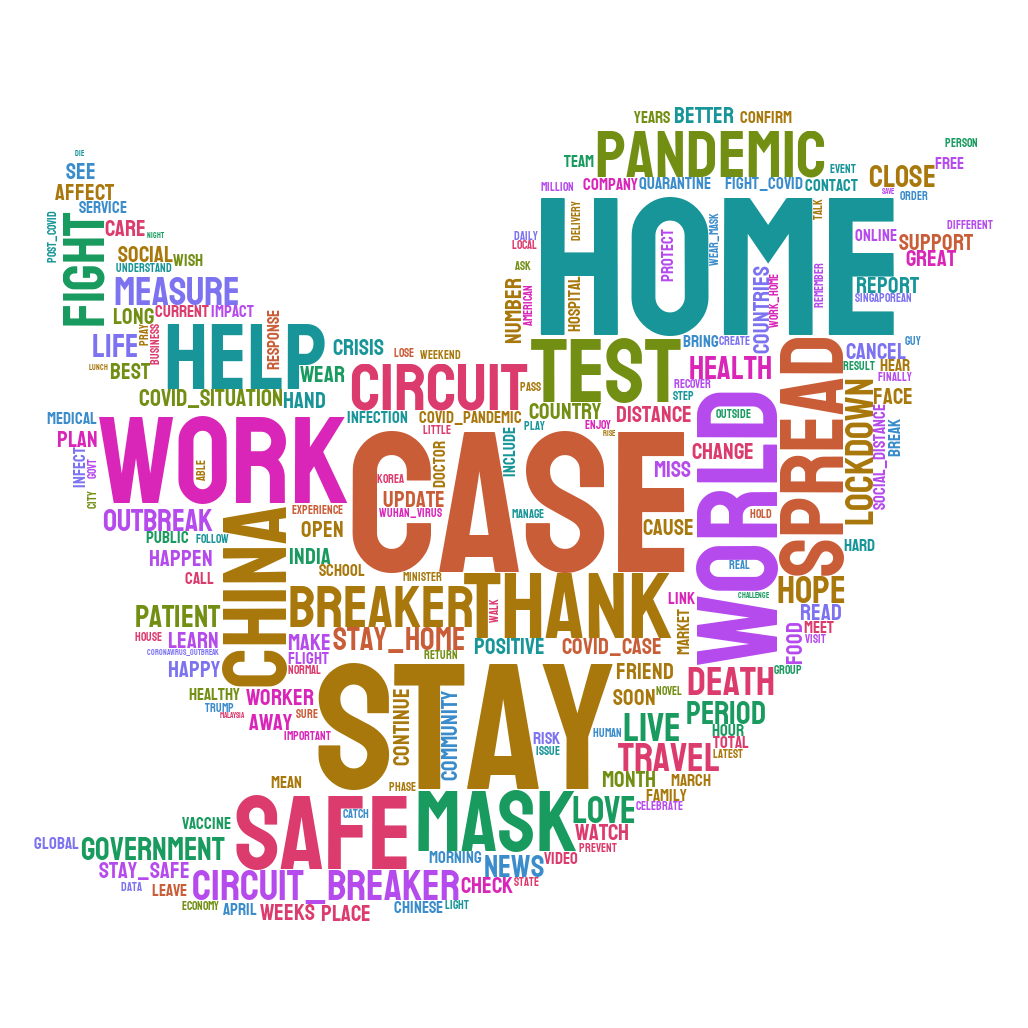

In [14]:
!pip install stylecloud
import stylecloud
from PIL import Image


tweets_df['cleaned_text'] = tweets_df['cleaned'].apply(lambda x: ' '.join(x))
long_string = ','.join(list(tweets_df['cleaned_text'].values))
stylecloud.gen_stylecloud(text=long_string, icon_name='fab fa-twitter', max_words=200, palette='cmocean.sequential.Phase_11', output_name='twitter-all-words.png', size = 1028, collocations=False)
Image.open('twitter-all-words.png')

# Hashtag analysis

In [15]:
def get_hashtags(text):
    list_of_hashtags = []
    temp = text.split()
    for word in temp:
        if word[0] == '#':
            list_of_hashtags.append(word)
    return list_of_hashtags

In [16]:
texts = list(tweets_df['Text'])
tweets_df['hashtags'] = [get_hashtags(text) for text in texts]

In [17]:
from collections import Counter

#Feb
all_hashtags = list(tweets_df[tweets_df['month'] == 2]['hashtags'])
all_hashtags = Counter([item for sublist in all_hashtags for item in sublist])
all_hashtags = pd.DataFrame.from_dict(all_hashtags, orient='index').reset_index()
all_hashtags.columns = ['hashtag', 'num']
all_hashtags['sum'] = np.sum(all_hashtags['num'])
all_hashtags['pct'] = 100 * all_hashtags['num']/all_hashtags['sum']
all_hashtags = all_hashtags.sort_values('pct', ascending = False).head(10)
all_hashtags

,hashtag,num,sum,pct
1,#coronavirus,128,732,17.486339
3,#Singapore,26,732,3.551913
83,#singapore,21,732,2.868852
15,#Coronavirus,17,732,2.322404
22,#COVID19,15,732,2.049180
157,#CoronavirusOutbreak,14,732,1.912568
135,#nCoV2019,13,732,1.775956
196,#WuhanCoronavirus,12,732,1.639344
113,#WuhanVirus,12,732,1.639344
173,#coronavirussingapore,12,732,1.639344


In [18]:
#Mar
all_hashtags = list(tweets_df[tweets_df['month'] == 3]['hashtags'])
all_hashtags = Counter([item for sublist in all_hashtags for item in sublist])
all_hashtags = pd.DataFrame.from_dict(all_hashtags, orient='index').reset_index()
all_hashtags.columns = ['hashtag', 'num']
all_hashtags['sum'] = np.sum(all_hashtags['num'])
all_hashtags['pct'] = 100 * all_hashtags['num']/all_hashtags['sum']
all_hashtags = all_hashtags.sort_values('pct', ascending = False).head(10)
all_hashtags

,hashtag,num,sum,pct
11,#coronavirus,235,1955,12.020460
9,#COVID19,109,1955,5.575448
18,#Covid_19,80,1955,4.092072
34,#covid_19,55,1955,2.813299
16,#covid19,44,1955,2.250639
59,#Singapore,37,1955,1.892583
193,#COVIDー19,25,1955,1.278772
78,#singapore,23,1955,1.176471
146,#Coronavirus,22,1955,1.125320
267,#COVID2019,15,1955,0.767263


In [19]:
#Apr
all_hashtags = list(tweets_df[tweets_df['month'] == 4]['hashtags'])
all_hashtags = Counter([item for sublist in all_hashtags for item in sublist])
all_hashtags = pd.DataFrame.from_dict(all_hashtags, orient='index').reset_index()
all_hashtags.columns = ['hashtag', 'num']
all_hashtags['sum'] = np.sum(all_hashtags['num'])
all_hashtags['pct'] = 100 * all_hashtags['num']/all_hashtags['sum']
all_hashtags = all_hashtags.sort_values('pct', ascending = False).head(10)
all_hashtags

,hashtag,num,sum,pct
27,#circuitbreaker,244,3369,7.242505
18,#coronavirus,114,3369,3.383793
15,#CircuitBreaker,73,3369,2.166815
4,#stayhome,72,3369,2.137133
26,#covid19,72,3369,2.137133
112,#Singapore,71,3369,2.107450
67,#COVID19,69,3369,2.048085
99,#singapore,64,3369,1.899673
23,#Covid_19,63,3369,1.869991
42,#circuitbreakersg,50,3369,1.484120


In [20]:
#May
all_hashtags = list(tweets_df[tweets_df['month'] == 5]['hashtags'])
all_hashtags = Counter([item for sublist in all_hashtags for item in sublist])
all_hashtags = pd.DataFrame.from_dict(all_hashtags, orient='index').reset_index()
all_hashtags.columns = ['hashtag', 'num']
all_hashtags['sum'] = np.sum(all_hashtags['num'])
all_hashtags['pct'] = 100 * all_hashtags['num']/all_hashtags['sum']
all_hashtags = all_hashtags.sort_values('pct', ascending = False).head(10)
all_hashtags

,hashtag,num,sum,pct
4,#circuitbreaker,157,2171,7.231690
25,#stayhome,62,2171,2.855827
9,#coronavirus,53,2171,2.441271
5,#circuitbreakersg,52,2171,2.395210
20,#covid19,51,2171,2.349148
6,#singapore,46,2171,2.118839
16,#Singapore,36,2171,1.658222
21,#covid_19,29,2171,1.335790
253,#Covid_19,25,2171,1.151543
153,#sgunited,22,2171,1.013358


In [21]:
#Jun
all_hashtags = list(tweets_df[tweets_df['month'] == 6]['hashtags'])
all_hashtags = Counter([item for sublist in all_hashtags for item in sublist])
all_hashtags = pd.DataFrame.from_dict(all_hashtags, orient='index').reset_index()
all_hashtags.columns = ['hashtag', 'num']
all_hashtags['sum'] = np.sum(all_hashtags['num'])
all_hashtags['pct'] = 100 * all_hashtags['num']/all_hashtags['sum']
all_hashtags = all_hashtags.sort_values('pct', ascending = False).head(10)
all_hashtags

,hashtag,num,sum,pct
18,#circuitbreaker,45,966,4.658385
33,#singapore,34,966,3.519669
13,#covid19,30,966,3.105590
74,#covid_19,20,966,2.070393
146,#stayhome,20,966,2.070393
59,#coronavirus,19,966,1.966874
9,#Singapore,18,966,1.863354
230,#stayathome,11,966,1.138716
222,#phase1reopening,10,966,1.035197
8,#CircuitBreaker,9,966,0.931677


In [22]:
#Jul
all_hashtags = list(tweets_df[tweets_df['month'] == 7]['hashtags'])
all_hashtags = Counter([item for sublist in all_hashtags for item in sublist])
all_hashtags = pd.DataFrame.from_dict(all_hashtags, orient='index').reset_index()
all_hashtags.columns = ['hashtag', 'num']
all_hashtags['sum'] = np.sum(all_hashtags['num'])
all_hashtags['pct'] = 100 * all_hashtags['num']/all_hashtags['sum']
all_hashtags = all_hashtags.sort_values('pct', ascending = False).head(10)
all_hashtags

,hashtag,num,sum,pct
15,#coronavirus,18,478,3.765690
40,#covid19,17,478,3.556485
5,#circuitbreaker,11,478,2.301255
3,#workfromhome,7,478,1.464435
14,#COVID__19,7,478,1.464435
9,#stayhomesg,6,478,1.255230
70,#phase2,6,478,1.255230
1,#homequarantine,6,478,1.255230
44,#singapore,6,478,1.255230
0,#untiltomorrow,6,478,1.255230


In [23]:
#Aug
all_hashtags = list(tweets_df[tweets_df['month'] == 8]['hashtags'])
all_hashtags = Counter([item for sublist in all_hashtags for item in sublist])
all_hashtags = pd.DataFrame.from_dict(all_hashtags, orient='index').reset_index()
all_hashtags.columns = ['hashtag', 'num']
all_hashtags['sum'] = np.sum(all_hashtags['num'])
all_hashtags['pct'] = 100 * all_hashtags['num']/all_hashtags['sum']
all_hashtags = all_hashtags.sort_values('pct', ascending = False).head(10)
all_hashtags

,hashtag,num,sum,pct
72,#COVID__19,4,126,3.174603
71,#Singapore,3,126,2.380952
68,#covid,3,126,2.380952
9,#covid19,3,126,2.380952
53,#covid_19,2,126,1.587302
10,#coronavirus,2,126,1.587302
14,#COVID19,2,126,1.587302
45,#pandemic,2,126,1.587302
97,#Covid_19,2,126,1.587302
0,#wfh,2,126,1.587302


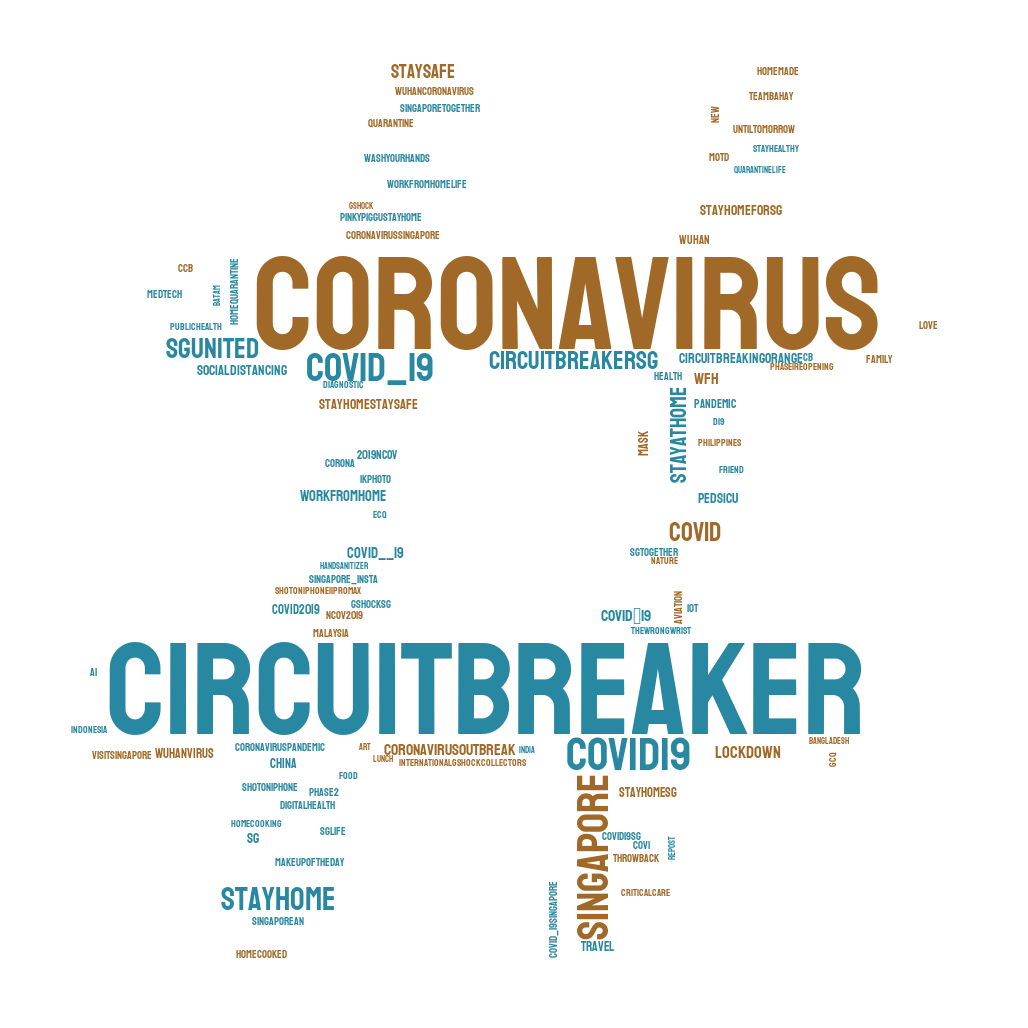

In [24]:
#Overall hashtags for all months
tweets_df['hashtags_texts'] = tweets_df['hashtags'].apply(lambda x: ' '.join(x))
long_string = ','.join(list(tweets_df['hashtags_texts'].values))
stylecloud.gen_stylecloud(text=long_string, icon_name='fas fa-hashtag', max_words=100, palette='cartocolors.diverging.Earth_2', output_name='hashtags.png', size = 1028, collocations=False)
Image.open('hashtags.png')
#tweets_df['hashtags_texts'].values
#long_string